seq2seq網絡架構:
![seq2seq 網絡架構](seq2seq.jpg)
Encoder 獲得輸入 [What , are , you , looking , at]，我們不關心encoder的輸出是什麽，只需要得到它最後的隱含狀態u就可以了，將它傳遞給decoder端即可<br><br>
而Decoder端在訓練時採用Teacher Forcing的方法，也就是說在Decoder端，正常情況下t-1時刻的輸出應該是當作t時刻的輸入<br>
但是使用了Teacher Forcing後，不管Decoder在上一個時刻的實際輸出的是什麽，就算是輸出錯的答案，t時刻的輸入永遠是t-1時刻的期望輸出(ground truth)<br><br>
例如訓練的目標為`[你 , 瞅 , 啥 , <EOS>]`，decoder端輸入就是`[<GO> , 你 , 瞅 , 啥]` <br>

# Build Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [2]:
PAD = 0
GO = 1
EOS = 10

vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units
batch_size = 100

- encoder_inputs  => shape : [encoder_max_time , batch_size]
- decoder_targets => int32 tensor is shaped : [decoder_max_time , batch_size]
- decoder_inputs  =>  int32 tensor is shaped : [decoder_max_time , batch_size]

In [3]:
encoder_inputs = tf.placeholder(shape = [batch_size , 8] ,
                                dtype = tf.int32 ,
                                name = 'encoder_inputs')

decoder_inputs = tf.placeholder(shape = [batch_size , 9] , 
                                dtype = tf.int32 ,
                                name = 'decoder_inputs')

decoder_targets = tf.placeholder(shape = [batch_size , 9] ,
                                 dtype = tf.int32 , 
                                 name = 'decoder_targets')

In [4]:
def lstm_cell(hidden_size): 
    cell = tf.contrib.rnn.LSTMCell(hidden_size , use_peepholes = True)
    return cell

def add_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0.01 , stddev = 0.1) , name = 'w')
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.01 , name = 'b')
    Wx_plus_b = tf.matmul(inputs , Weights) + biases

    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)
    
    return outputs

## Embeddings & Encoder


In [5]:
with tf.variable_scope('embedding'):  
    embeddings = tf.Variable(tf.random_uniform([vocab_size , input_embedding_size] , -1.0 , 1.0),
                             dtype = tf.float32) # -> (10, 20) 
    encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings , encoder_inputs) # -> (100 , 8 , 20)
    decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings , decoder_inputs) # -> (100 , 9 , 20)
    
with tf.variable_scope('encoder_LSTM'):    
    encoder_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(encoder_hidden_units) for _ in range(1)] , 
                                                state_is_tuple = True) 
   
    encoder_state = encoder_cell.zero_state(batch_size , dtype = tf.float32)
    encoder_outputs , encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, 
                                                              encoder_inputs_embedded,
                                                              dtype = tf.float32,
                                                              time_major = False)    

## Decoder

In [6]:
with tf.variable_scope('decoder_LSTM'):
    decoder_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(decoder_hidden_units) for _ in range(1)] , 
                                                state_is_tuple = True) 

    decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, 
                                                             decoder_inputs_embedded,
                                                             initial_state = encoder_final_state,
                                                             dtype = tf.float32, 
                                                             time_major = False)
    
    decoder_outputs_ = tf.reshape(decoder_outputs , [-1 , decoder_hidden_units])

## Fully Connected

In [7]:
with tf.variable_scope('fully_connected'):
    decoder_prediction = add_layer(decoder_outputs_ , 
                                   decoder_hidden_units , 
                                   vocab_size , 
                                   activaction_function = tf.nn.softmax) # -> (900, 10) 
    decoder_prediction_ = tf.argmax(decoder_prediction , axis = 1) # -> (900, )
    decoder_prediction_visualize = tf.reshape(decoder_prediction_ , [batch_size , 9]) # -> (100, 9)

decoder_targets_onehot = tf.one_hot(decoder_targets , vocab_size) # -> (100, 9, 10)
decoder_targets_onehot = tf.reshape(decoder_targets_onehot , [-1 , vocab_size]) # -> (900, 10)    

## Optimizer

In [8]:
croee_entropy_temp = -tf.reduce_sum(decoder_targets_onehot * tf.log(decoder_prediction) , axis = 1)
croee_entropy = tf.reduce_mean(croee_entropy_temp)
train_op = tf.train.AdamOptimizer().minimize(croee_entropy)

In [9]:
# 產生一個batch訓練資料
def random_sequences(length_from , length_to , vocab_lower , vocab_upper , batch_size):

    encoder_inputs_ = [[] for _ in range(0 , batch_size)]
    
    for i in range(0 , batch_size):
        num = random.randint(length_from , length_to) 
        encoder_inputs_[i] = random.sample(range(vocab_lower , vocab_upper) , num)

    return encoder_inputs_

def zeros_padding(encoder_inputs_ , max_len , PAD , GO , EOS):
    decoder_targets_ = [[] for _ in range(0 , len(encoder_inputs_))]
    for i in range(0 , len(encoder_inputs_)):
        decoder_targets_[i] = encoder_inputs_[i] + [EOS]
    
    decoder_inputs_ = [[] for _ in range(0 , len(encoder_inputs_))]
    for i in range(0 , len(encoder_inputs_)):
        decoder_inputs_[i] = [GO] + encoder_inputs_[i]  
        
    for i in range(0 , len(encoder_inputs_)):
        while len(encoder_inputs_[i]) < max_len:
            encoder_inputs_[i].append(PAD)
    
    for i in range(0 , len(decoder_targets_)):
        while len(decoder_targets_[i]) < max_len + 1:
            decoder_targets_[i].append(PAD)    
    
    for i in range(0 , len(decoder_inputs_)):
        while len(decoder_inputs_[i]) < max_len + 1:
            decoder_inputs_[i].append(PAD)  
    
    encoder_inputs_ = np.array(encoder_inputs_) 
    decoder_targets_ = np.array(decoder_targets_) 
    decoder_inputs_ = np.array(decoder_inputs_) 
         
    return encoder_inputs_ , decoder_targets_ , decoder_inputs_ 

In [10]:
encoder_inputs_ = random_sequences(length_from = 3 , 
                                   length_to = 8 ,
                                   vocab_lower = 2 , 
                                   vocab_upper = 9 + 1 ,
                                   batch_size = 100)

encoder_inputs_ , decoder_targets_ , decoder_inputs_ = zeros_padding(encoder_inputs_ = encoder_inputs_ , 
                                                                     max_len = 8 , 
                                                                     PAD = PAD , 
                                                                     GO = GO ,
                                                                     EOS = EOS)

print('encoder input : {}'.format(encoder_inputs_[0]))
print('decoder_target : {} , 10 代表 <EOS>'.format(decoder_targets_[0]))
print('decoder_input : {} ,  1 代表 <GO>'.format(decoder_inputs_[0]))

encoder input : [2 3 9 8 0 0 0 0]
decoder_target : [ 2  3  9  8 10  0  0  0  0] , 10 代表 <EOS>
decoder_input : [1 2 3 9 8 0 0 0 0] ,  1 代表 <GO>


## Training 

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

max_batches = 4001
batches_in_epoch = 1000
loss_his = []
for batch_i in range(0 , max_batches):
    
    encoder_inputs_ = random_sequences(length_from = 3 , 
                                       length_to = 8 ,
                                       vocab_lower = 2 , 
                                       vocab_upper = 9 + 1 ,
                                       batch_size = 100)
    
    encoder_inputs_ , decoder_targets_ , decoder_inputs_ =\
    zeros_padding(encoder_inputs_ = encoder_inputs_ , 
                  max_len = 8 , 
                  PAD = PAD , 
                  GO = GO ,
                  EOS = EOS)
    
    feed_dict = {encoder_inputs : encoder_inputs_ , decoder_targets : decoder_targets_ , decoder_inputs : decoder_inputs_}
    _ , loss = sess.run([train_op, croee_entropy] , feed_dict = feed_dict)
    loss_his.append(loss)

    if batch_i == 0 or batch_i % batches_in_epoch == 0:
        loss = sess.run(croee_entropy, feed_dict = feed_dict)
        predict_ = sess.run(decoder_prediction_visualize , feed_dict = feed_dict)
        
        print('=' * 50)
        print('batch : {}'.format(batch_i))
        print('minibatch loss : {:.2f}'.format(loss))
        
        for i in range(0 , batch_size):
            print('~' * 40)
            print('sample : {}'.format(i + 1))
            print('input : {}'.format(encoder_inputs_[i]))
            print('predict : {}'.format(predict_[i]))
            if i >= 5 : break

batch : 0
minibatch loss : 2.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 1
input : [4 8 9 5 2 0 0 0]
predict : [4 5 3 1 3 3 4 4 4]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 2
input : [8 5 2 3 9 4 0 0]
predict : [5 3 3 3 6 6 3 6 6]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 3
input : [4 3 2 9 6 7 8 0]
predict : [4 3 6 4 6 4 4 3 3]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 4
input : [5 4 9 2 8 3 0 0]
predict : [5 4 3 4 4 3 6 3 6]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 5
input : [9 5 4 3 2 8 0 0]
predict : [5 4 4 3 6 6 3 3 3]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 6
input : [8 9 3 0 0 0 0 0]
predict : [5 3 4 6 6 6 4 4 4]
batch : 1000
minibatch loss : 0.25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 1
input : [5 4 3 2 8 6 7 0]
predict : [5 4 3 2 8 6 7 5 0]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 2
input : [4 5 8 7 9 2 0 0]
predict : [4 5 8 7 9 2 3 0 0]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample : 3
input : [2 5 3 7 

Text(0,0.5,'loss')

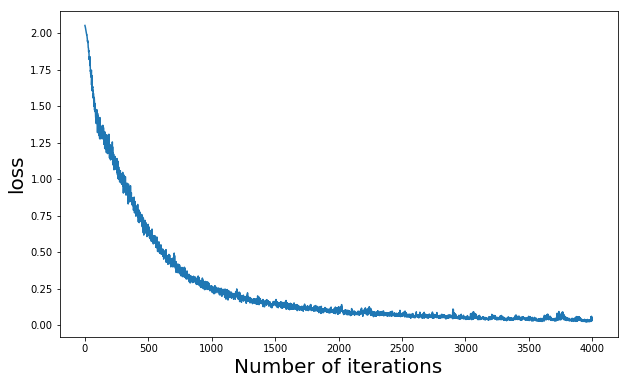

In [12]:
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(loss_his)) , np.array(loss_his)) 
ax.set_xlabel('Number of iterations' , fontsize = 20)
ax.set_ylabel('loss' , fontsize = 20)